In [11]:
###paths#####
#############
import sys
import os

pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############
# 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import psycopg2
import plotly.graph_objects as go
import pandas as pd


from numerical.cn_plot import plot1D, surfpattern
from database.databaseFunctions import *
from analytical.linear_stability_analysis import *
from randomfunctions import *

from matplotlib.colors import ListedColormap
import seaborn as sns
my_cmap = ListedColormap(sns.color_palette('turbo', 256))   
my_cmap = ListedColormap(sns.color_palette("Spectral",256)) 
sns.set_context('poster')



In [28]:
model_param_id = '8890642_circuit:turinghill_variant:11_samples:1000000'

L=25; dx =0.05; J = int(L/dx)
T =2000; dt = 0.005; N = int(T/dt)
rate=L/T
folder = 'turinghill_variant11'
parIDssID = f'{8890642}.{0}'
mechanism= 'edgegrowth2'

nogrowth_simulation_param_uuid = '132323a4-3f93-4287-aca9-d18e84848e37'
openboundary_simulation_param_uuid = '6952d306-f619-4af1-963c-aa28acb132df'
edgegrowth2_simulation_param_uuid = 'b94c9e61-a717-4470-957b-a59ff727e948'

simulation_param_uuid_list = [nogrowth_simulation_param_uuid, openboundary_simulation_param_uuid, edgegrowth2_simulation_param_uuid]


## Save simulation

In [27]:
for simulation_param_uuid, boundaryCoeff, mechanism in zip(simulation_param_uuid_list, [1,2,2], ['nogrowth', 'openboundary', 'edgegrowth2']):
    filename= lambda mechanism, parID: 'circuit%s_variant%s_bc%s_%s_rate%s_ID%s_L%r_J%r_T%r_N%r'%('turinghill','11',boundaryCoeff, mechanism,rate,parID,L,J,T,N)
    if simulation_param_uuid == edgegrowth2_simulation_param_uuid:
        masking=True
    else:
        masking=False
        
    U_record = query_simulationOutput_single_from_sql_from_id(model_param_id,simulation_param_uuid,'U_record_1D', ssID=0)
    U_final = np.stack([U_record_morphogen[-1,:] for U_record_morphogen in U_record])
    
    with open(modellingpath + f'/growth/out/numerical/{mechanism}/simulation/{folder}/1Dfinal_{filename(mechanism,parIDssID)}.pkl', 'wb') as f:
        pickle.dump(U_final, f)
    with open(modellingpath + f'/growth/out/numerical/{mechanism}/simulation/{folder}/1Drecord_{filename(mechanism,parIDssID)}.pkl', 'wb') as f:
        pickle.dump(U_record, f)

## Load simulation

In [30]:
U_final= pickle.load( open(modellingpath + f"/growth/out/numerical/{mechanism}/simulation/{folder}/1Dfinal_{filename(mechanism,parIDssID)}.pkl", "rb"))
U_record= pickle.load( open(modellingpath + f"/growth/out/numerical/{mechanism}/simulation/{folder}/1Drecord_{filename(mechanism,parIDssID)}.pkl", "rb"))


## Plotting

In [31]:
def plot1D(U,dx=0.05,morphogen='both', savefig=False,filename='fig1e',savefigpath='',pad=0.001,round=False, plotPeaks=False, peaks=False, L=1):

    if round==True:
        U = np.round(U,decimals=3)
    
    if morphogen == 0:
        plt.plot(U[0], label='A')
    if morphogen ==1: 
        plt.plot(U[1], label='I')
    if morphogen == 'both': 
        fig,ax = plt.subplots()
        ax.plot(U[0], label='A', color='blue')
        ax.set_ylim(np.amin(U[0])-pad, np.amax(U[0])+pad)
        ax.legend(loc=(0.25,0.75)) #upper left
        # ax.ticklabel_format(useOffset=False)

        ax2=ax.twinx()
        ax2.plot(U[1], label='I', color='red')
        ax2.set_ylim(np.amin(U[1])-pad, np.amax(U[1])+pad)
        ax2.legend(loc=(0.55,0.75)) #upper right


        # ax.ticklabel_format(useOffset=False)

        locs, labels = plt.xticks()
        new_labels=locs*dx
        plt.xticks(ticks=locs, labels=new_labels)
        plt.xlim(0,len(U[0]))
        if plotPeaks==True:
            ax.plot(peaks[0],U[0][peaks[0]], 'o', color='blue')
            ax2.plot(peaks[1],U[1][peaks[1]], 'o', color='red')


    # plt.ticklabel_format(useOffset=False)
    plt.xlabel('Space')
    plt.ylabel('Concentration')
    if savefig==True:
        plt.savefig('%s%s.pdf'%(savefigpath,filename))
        plt.show()
        plt.close()
    else:
        plt.show()

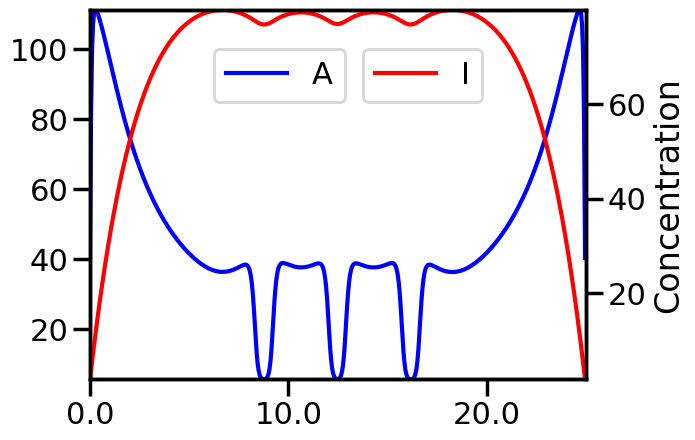

In [32]:
plot1D(U_final, savefig=True)

In [33]:

def surfpattern_growth(results,L,dx,J,T, masking=False, record_every_x_hours=10,growth='linear', rate=0, morphogen = 0,savefig=False,filename='',savefigpath='',logResults=False, normalize=False, cmap=my_cmap, space_crop=None):
    
    def create_growth_mask(shape):
        height, width = shape
        middle_point = width // 2
        mask = np.zeros((height, width))

        for t in range(height):
            growth_extent = int(1 + t*width/2/height)
            start = max(middle_point - growth_extent, 0)
            end = min(middle_point + growth_extent, width)
            mask[t, start:end] = 1
            
        return mask

    mask = create_growth_mask(np.shape(results[0]))




    dx = float(L)/float(J-1)
    x_grid = np.array([j*dx for j in range(J)])
    t_grid = np.arange(0,T,10) 
    
    if normalize == True:
        print('NEEDS NORMALIZATION')
    results = results[morphogen]
    if masking == True:
        results = results * mask
        # Create a masked array where zeros are masked
        results = np.ma.masked_where(results == 0, results)


    values = results.reshape(len(x_grid),len(t_grid))
    x, t = np.meshgrid(x_grid, t_grid)

    # t,x = np.meshgrid(t_grid, x_grid)
    # plt.contourf(t,x,results, cmap=cmap)]

    
    print(np.shape(x), np.shape(t), np.shape(results))
    plt.contourf(x,t,results, levels=100, cmap=my_cmap)
    if logResults==True:
        plt.colorbar(label='Concentration (logscale)')
    else:
        plt.colorbar()


    plt.ylabel('Time')
    plt.xlabel('Space')
    if savefig==True:
        plt.savefig('%s%s.pdf'%(savefigpath,filename))
        plt.show()
        plt.close()

    else:
        plt.show()

(200, 500) (200, 500) (200, 500)


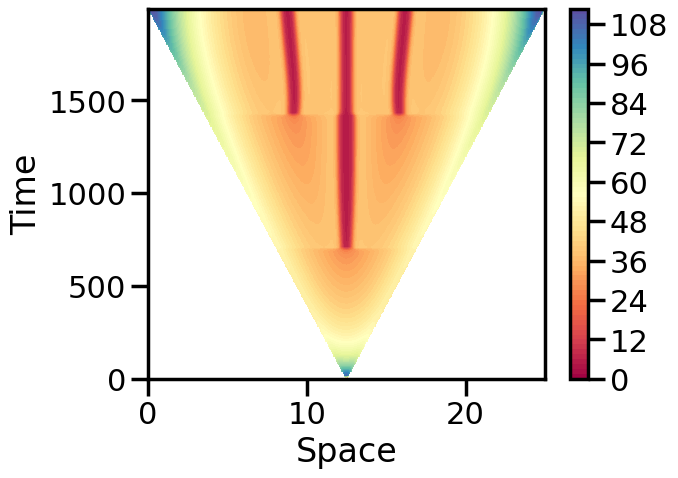

In [35]:
surfpattern_growth(U_record,L,dx,J,T,masking=masking, morphogen=0, savefig=True,filename='fig_1d')
